In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from nltk.corpus import stopwords
from yellowbrick.cluster import KElbowVisualizer # For visualizing elbow for best KMeans Clusters
import re
import pickle
%matplotlib inline
plt.style.use('ggplot')

In [64]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')          
stopWords = list(stopwords.words('english'))   

def is_stock_up(row):
    return True if row[1] < row[4] else False


def tokenize_paragraph(paragraph):
    raw_sentences = tokenizer.tokenize(paragraph)
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(sentence_to_wordlist(raw_sentence.lower()))
    return sentences
            
        
def remove_stopwords(sentences):
    sent_remove_stopwords = []
    for sent in sentences:
        append_sent = []
        for word in sent:
            if word not in stopWords:
                append_sent.append(word)
        sent_remove_stopwords.append(append_sent)
    return sent_remove_stopwords
        
            
def clean_text(paragraph):
    paragraph = paragraph.replace(u'\xa0', u' ')
    sentences = tokenize_paragraph(paragraph)
    sent_remove_stopwords = remove_stopwords(sentences)
    words = []
    for sent in sent_remove_stopwords:
        for word in sent:
            words.append(word)
    return words

#check gensim
def get_paragraph_vectors(tokens): 
    num_tokens = len(tokens)
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokens)]
    global model
    model = Doc2Vec(documents, vector_size=300, window=2, min_count=3, workers=10, epochs=25)       
    return [model.docvecs[i] for i in range(num_tokens)]

#check gensim
def get_infered_vectors(tokens):
    return model.infer_vector(tokens)
       
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

def reduce_dimensions(vectors):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=42)
    vectors = tsne.fit_transform(vectors)

    X = [v[0] for v in vectors]
    y = [v[1] for v in vectors]
    return X, y

def get_numpy_array(pandas_series, num_features=300):
    zeroes = np.empty((len(pandas_series),num_features))
    i = 0
    for vectors in pandas_series:
        zeroes[i] = np.array(vectors)
        i+=1
    return zeroes

def get_autoencoder_result(numpy_array):
    encoded_text = encoder.predict(numpy_array)
    return decoder.predict(encoded_text)

def get_vector_difference(initial_vector, decoded_vector):
    return np.absolute(initial_vector.sum() - decoded_vector.sum())

#check gensim
def get_word_vectors(model):
    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.key_to_index:
        vectors.append(model.wv[word])
        labels.append(word)
    return vectors, labels

In [2]:
df = pd.read_csv('cleaned_wsb.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310648 entries, 0 to 1310647
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Unnamed: 0    1310648 non-null  int64 
 1   body          1310648 non-null  object
 2   created_utc   1310648 non-null  object
 3   is_submitter  1310648 non-null  bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 31.2+ MB


In [4]:
df = df.drop('Unnamed: 0',axis=1)
df.head()

,body,created_utc,is_submitter
0,1:11am here no fucking shot I’m sleeping anyti...,2021-01-11 08:11:51,False
1,"Buy calls at open, everyone person alive is go...",2021-01-11 08:11:49,False
2,Twitter going down,2021-01-11 08:11:48,False
3,Kinda sucks though. Missing out on the opportu...,2021-01-11 08:11:46,False
4,U think first time investors won’t panic when ...,2021-01-11 08:11:43,False


In [5]:
df.created_utc = pd.DatetimeIndex(data=df.created_utc,tz='Etc/Universal')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310648 entries, 0 to 1310647
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype                        
---  ------        --------------    -----                        
 0   body          1310648 non-null  object                       
 1   created_utc   1310648 non-null  datetime64[ns, Etc/Universal]
 2   is_submitter  1310648 non-null  bool                         
dtypes: bool(1), datetime64[ns, Etc/Universal](1), object(1)
memory usage: 21.2+ MB


In [6]:
df.head()

,body,created_utc,is_submitter
0,1:11am here no fucking shot I’m sleeping anyti...,2021-01-11 08:11:51+00:00,False
1,"Buy calls at open, everyone person alive is go...",2021-01-11 08:11:49+00:00,False
2,Twitter going down,2021-01-11 08:11:48+00:00,False
3,Kinda sucks though. Missing out on the opportu...,2021-01-11 08:11:46+00:00,False
4,U think first time investors won’t panic when ...,2021-01-11 08:11:43+00:00,False


In [7]:
df.sort_values('created_utc', inplace=True)
df.head()

,body,created_utc,is_submitter
44267,"thanks, friend. he was late eighties, so had a...",2021-01-01 00:30:04+00:00,False
44266,I get that but when you win a bet take some of...,2021-01-01 00:30:06+00:00,False
44264,"Looking through my notes on my computer, ive d...",2021-01-01 00:30:07+00:00,False
44265,This is probably a little excessive my g,2021-01-01 00:30:07+00:00,False
44263,"Acid, nitrous, and weed as I solo dolo into 20...",2021-01-01 00:30:10+00:00,False


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1310648 entries, 44267 to 92
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype                        
---  ------        --------------    -----                        
 0   body          1310648 non-null  object                       
 1   created_utc   1310648 non-null  datetime64[ns, Etc/Universal]
 2   is_submitter  1310648 non-null  bool                         
dtypes: bool(1), datetime64[ns, Etc/Universal](1), object(1)
memory usage: 31.2+ MB


In [9]:
df.created_utc = df.created_utc.apply(lambda timestamp : timestamp.tz_convert('US/Eastern'))

In [10]:
df.head()

,body,created_utc,is_submitter
44267,"thanks, friend. he was late eighties, so had a...",2020-12-31 19:30:04-05:00,False
44266,I get that but when you win a bet take some of...,2020-12-31 19:30:06-05:00,False
44264,"Looking through my notes on my computer, ive d...",2020-12-31 19:30:07-05:00,False
44265,This is probably a little excessive my g,2020-12-31 19:30:07-05:00,False
44263,"Acid, nitrous, and weed as I solo dolo into 20...",2020-12-31 19:30:10-05:00,False


In [11]:
stocks = ['GME.csv','BB.csv','AMC.csv','NOK.csv','PLTR.csv','TSLA.csv']
df_stocks = []
for stock in stocks:
    df_stocks.append(pd.read_csv(stock))

In [12]:
filtered_stocks = []
for frame in df_stocks:
    frame.Date = pd.DatetimeIndex(data=frame.Date)
    filtered_stocks.append(frame[frame.Date >= datetime(2021, 1, 1)])
    

In [13]:
df_stocks = []
for frame in filtered_stocks:
    frame.Date = pd.DatetimeIndex(data=frame.Date,tz='Etc/Universal')
    frame.Date = frame.Date.apply(lambda timestamp : timestamp.tz_convert('US/Eastern'))
    df_stocks.append(frame)

In [14]:
for frame in df_stocks:
    frame['is_stock_up'] = frame.apply(is_stock_up,axis=1)

In [15]:
df_stocks[1].head()

,Date,Open,High,Low,Close,Adj Close,Volume,is_stock_up
5514,2021-01-03 19:00:00-05:00,6.70,6.82,6.52,6.58,6.58,11139200,False
5515,2021-01-04 19:00:00-05:00,6.62,6.80,6.56,6.77,6.77,9108900,True
5516,2021-01-05 19:00:00-05:00,6.71,6.91,6.63,6.71,6.71,11022300,False
5517,2021-01-06 19:00:00-05:00,6.75,7.12,6.72,7.06,7.06,13062800,True
5518,2021-01-07 19:00:00-05:00,7.22,7.64,7.10,7.56,7.56,23039300,True


In [25]:
df['tokens'] = df.body.apply(clean_text)
df.head()

,body,created_utc,is_submitter,tokens
44267,"thanks, friend. he was late eighties, so had a...",2020-12-31 19:30:04-05:00,False,"[thanks, friend, late, eighties, good, life, t..."
44266,I get that but when you win a bet take some of...,2020-12-31 19:30:06-05:00,False,"[get, win, bet, take, winning, ffs, even, k, a..."
44264,"Looking through my notes on my computer, ive d...",2020-12-31 19:30:07-05:00,False,"[looking, notes, computer, ive, done, much, dd..."
44265,This is probably a little excessive my g,2020-12-31 19:30:07-05:00,False,"[probably, little, excessive, g]"
44263,"Acid, nitrous, and weed as I solo dolo into 20...",2020-12-31 19:30:10-05:00,False,"[acid, nitrous, weed, solo, dolo, bc, quaranti..."


In [28]:
test_df = df.iloc[:50,]
test_df

,body,created_utc,is_submitter,tokens
44267,"thanks, friend. he was late eighties, so had a...",2020-12-31 19:30:04-05:00,False,"[thanks, friend, late, eighties, good, life, t..."
44266,I get that but when you win a bet take some of...,2020-12-31 19:30:06-05:00,False,"[get, win, bet, take, winning, ffs, even, k, a..."
44264,"Looking through my notes on my computer, ive d...",2020-12-31 19:30:07-05:00,False,"[looking, notes, computer, ive, done, much, dd..."
44265,This is probably a little excessive my g,2020-12-31 19:30:07-05:00,False,"[probably, little, excessive, g]"
44263,"Acid, nitrous, and weed as I solo dolo into 20...",2020-12-31 19:30:10-05:00,False,"[acid, nitrous, weed, solo, dolo, bc, quaranti..."
44262,Hey me too!,2020-12-31 19:30:11-05:00,False,[hey]
44261,"280 is the strike price and im down 94,15%",2020-12-31 19:30:12-05:00,False,"[strike, price, im]"
44260,🍄,2020-12-31 19:30:14-05:00,False,[]
44259,Hey whats a margiin call? I keep hearing about...,2020-12-31 19:30:14-05:00,False,"[hey, whats, margiin, call, keep, hearing, buy..."
44258,"My sticky nerdy dongus is ready to be eaten, t...",2020-12-31 19:30:20-05:00,False,"[sticky, nerdy, dongus, ready, eaten, take, pltr]"


In [38]:
# raw_corpus = ''
# row_count = 0
# for row in df.body:    
#     print('Adding to raw_corpus... \n row_num is {row_count}'.format(row_count=row_count))
#     row_count += 1
#     raw_corpus += row
    
%time raw_corpus = ' '.join([x for x in df.body]) #faster code

Wall time: 407 ms


In [43]:
len(raw_corpus)

144600150

In [39]:
raw_corpus = raw_corpus.replace(u'\xa0', u' ')

In [40]:
raw_sentences = tokenizer.tokenize(raw_corpus)

In [41]:
%time sentences = [sentence_to_wordlist(raw_sentence.lower())for raw_sentence in raw_sentences if len(raw_sentence) > 0]

Wall time: 15.3 s


In [44]:
sent_remove_stopwords = []
for sent in sentences:
    append_sent = []
    for word in sent:
        if word not in stopWords:
            append_sent.append(word)
    sent_remove_stopwords.append(append_sent)
        
            

In [49]:
model = Word2Vec(sentences=sent_remove_stopwords, vector_size=300, workers=10, epochs=25)


In [94]:
filename = 'single_words.sav'
pickle.dump(model, open(filename, 'wb'))

In [85]:
vectors, words = get_word_vectors(model)

In [68]:
X = np.array(vectors).reshape(len(vectors),len(vectors[0]))

Text(0.5, 1.0, 'The Elbow Method using Distortion')

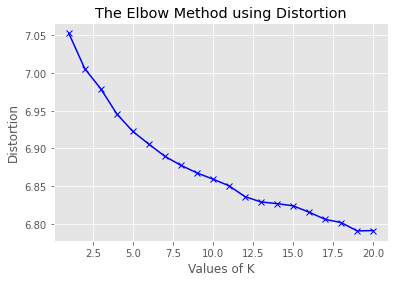

In [72]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')

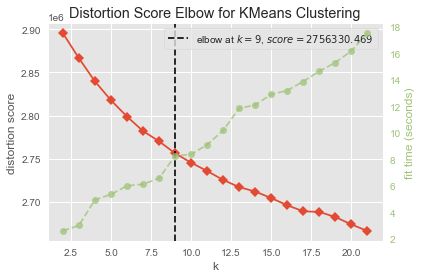

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [81]:
reshaped_vec = np.array(vectors).reshape(len(vectors),len(vectors[0]))
km = KMeans()
visualizer = KElbowVisualizer(km, k=(2,22))
visualizer.fit(reshaped_vec)
visualizer.show()

In [82]:
best_elbow = visualizer.elbow_value_
best_elbow

9

In [83]:
km = KMeans(n_clusters=best_elbow)
km.fit(reshaped_vec.astype('double'))
labels = km.labels_

In [84]:
tsne_X, tsne_y = reduce_dimensions(vectors)

In [91]:
word_df = pd.DataFrame({'word':words,'tsne_X':tsne_X,'tsne_y':tsne_y,'labels':labels})

In [92]:
word_df.to_csv('single_word.csv')